In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
import pandas as pd
from codex import io as codex_io
from codex import config as codex_config
from codex.ops import illumination_correction
from skimage import exposure
from skimage import io as sk_io
plt.gray()
SEED=5512
None

<Figure size 432x288 with 0 Axes>

In [2]:
import logging
console = logging.StreamHandler()
console.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s:%(name)s: %(message)s'))
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(console)

In [24]:
# exp_name = '7-7-17-multicycle'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-cytokit', 'output', 'v01')
# nuc_midx = 7
# nuc_ch_name = 'ci:HOECHST1'

# exp_name = '2018-01-09-Run0'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name + '-Clean', 'output', 'v00')
# nuc_midx = 6
# nuc_ch_name = 'ci:HOECHST1'

# exp_name = '20180706-Donor22-R2-Tcell-CODEX_CD3CD4CD85BY5'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01')
# nuc_midx = 5
# nuc_ch_name = 'ci:DAPI'

# exp_name = '20180706-Donor23-R2-Tcell-CODEX_CD3CD4CD85BY5'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01')
# nuc_midx = 5
# nuc_ch_name = 'ci:DAPI'

exp_name = '20180614_D22_RepA_Tcell_CD4-CD8-DAPI_5by5'
exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v03')
nuc_midx = 5
nuc_ch_name = 'ci:DAPI'

# exp_name = '20180802-Donor7_Tcell-CODEX_CD3CD4CD8_7BYB7'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v02')
# nuc_midx = 5
# nuc_ch_name = 'ci:DAPI'

# exp_name = 'RS002_CODEX_Tonsil_180426'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', 'wherrylab', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'wherrylab', exp_name, '2018_08_02_RS002_processed_cytokit', 'output', 'v01')
# nuc_midx = 6
# nuc_ch_name = 'ci:HOECHST2'

config = codex_config.load(exp_conf_dir)

In [19]:
config._conf['processor']['illumination_correction']

{'channel_mapping': {'CD4': 'CD4', 'CD8': 'CD8', 'DAPI': 'DAPI'},
 'model_params': {'n_estimators': 5, 'type': 'gbr'},
 'overwrite_tile': True}

In [20]:
ic_conf = {
    'channel_mapping': {'DAPI': 'DAPI', 'CD4': 'CD4', 'CD8': 'CD8'},
#     'channel_mapping': {'HOECHST1': 'HOECHST1'},
    'feature_params': {
        'region': {'degree': 3, 'type': 'polynomial'},
        'tile': {'degree': 3, 'type': 'polynomial'},
        'index': {'degree': 3, 'type': 'polynomial'}
    },
    'filter_params': {
        'features': ['cell_size'],
        'max_cells': 250000,
        'percentile_range': [0.01, 0.99]
    },
    'model_params': {'type': 'ls'},
#     'model_params': {'type': 'mlp'},
#     'model_params': {'type': 'mlp', 'args': {'activation': 'relu', 'hidden_layer_sizes': (15,)}},
#     'model_params': {'type': 'mlp', 'args': {'activation': 'logistic', 'hidden_layer_sizes': (50,)}},
    #'model_params': {'type': 'huber', 'args': {'alpha': .1}},
    #'model_params': {'type': 'gbr', 'args': {'n_estimators': 100}},
#     'model_params': {'type': 'ridge', 'args': {'alpha': .000001}},
    'prediction_params': {'sampling_rate': 10}
}
config._conf['processor']['illumination_correction'] = ic_conf

In [21]:
import imp
imp.reload(illumination_correction)

<module 'codex.ops.illumination_correction' from '/lab/repos/codex/python/pipeline/codex/ops/illumination_correction.py'>

In [22]:
op = illumination_correction.IlluminationCorrection(config)

In [23]:
op.prepare_region_data(exp_data_dir)

KeyError: 'ci:CD4'

In [9]:
est = op.data[0][1]['HOECHST1']

KeyError: 0

In [338]:
# PolynomialFeatures(degree=7).fit_transform(np.array([[1,2],[3,4]])).shape

In [339]:
#est.named_steps['est'].coef_
est.coef_.shape

(148,)

In [340]:
#img_ic = op.data[0][0]['DAPI']
#img_ic = op.data[0][0]['CD8']
#img_ic = op.data[0][0]['HOECHST2']
img_ic = op.data[0][0]['HOECHST1']
img_ic.shape

(5040, 6720)

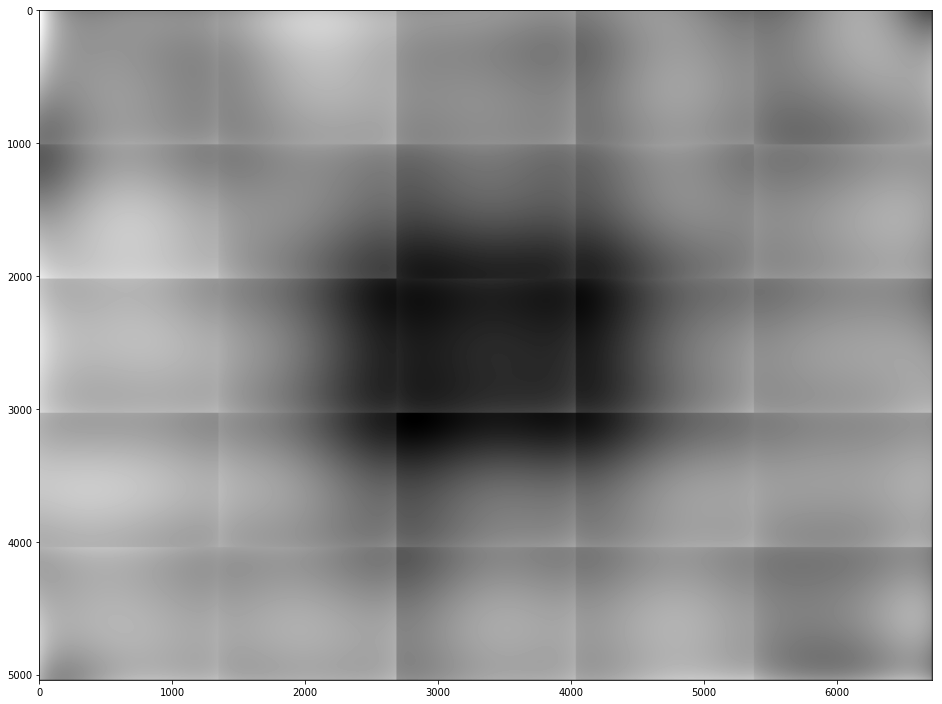

In [354]:
plt.imshow(img_ic)
plt.gcf().set_size_inches(16, 16)
#plt.colorbar()

Load original image to compare to:

In [350]:
#img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'hoechst'))
img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(0, 'best_z_segm'))
#img_path = osp.join(exp_data_dir, codex_io.get_montage_image_path(1, 'best_z_segm'))
img_path

'/lab/data/2018-01-09-Run0-Clean/output/v00/montage/best_z_segm/R001.tif'

In [351]:
img = codex_io.read_tile(img_path)
img.shape

(1, 1, 7, 5040, 6720)

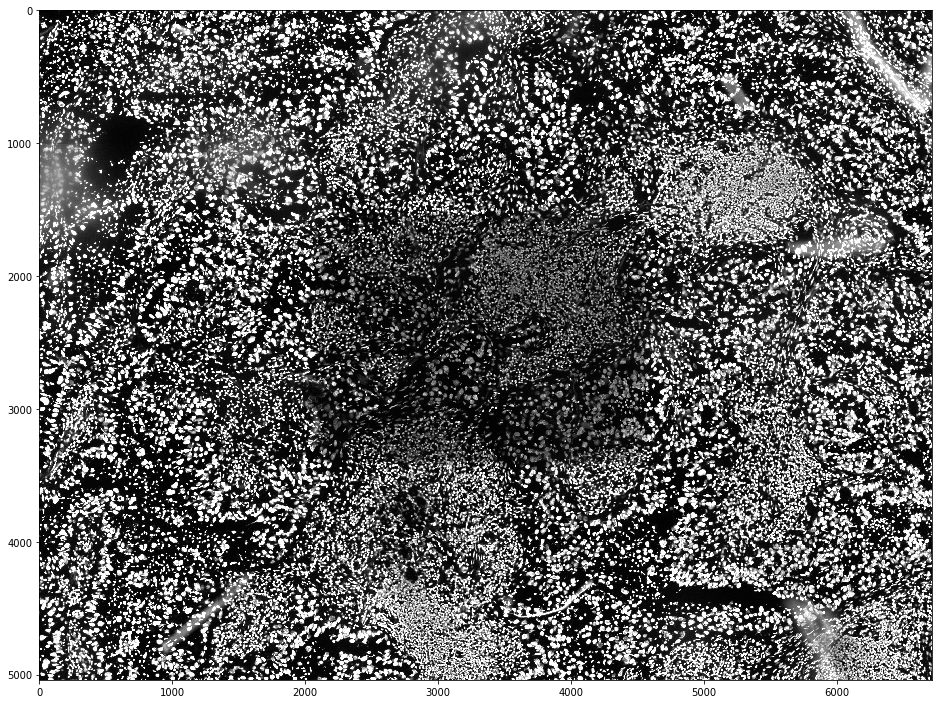

In [358]:
img_orig = img[0, 0, nuc_midx]
plt.imshow(img_orig.clip(0, 75))
#plt.imshow(img_orig.clip(0, 10000))
#plt.imshow(img_orig)
plt.gcf().set_size_inches(16, 16)

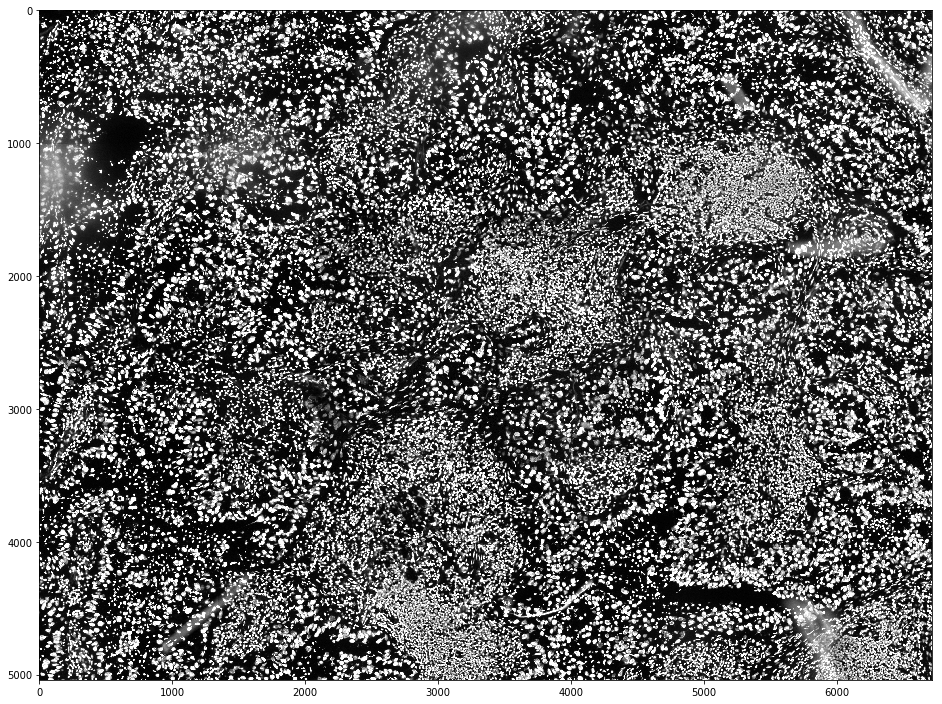

In [359]:
img_res = img[0, 0, nuc_midx] / img_ic
#plt.imshow(img_res)
plt.imshow(img_res.clip(0, 75))
#plt.imshow(img_res.clip(0, 10000))
plt.gcf().set_size_inches(16, 16)

2018-08-25 04:44:01,767:DEBUG:matplotlib.font_manager: findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.5/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
2018-08-25 04:44:01,769:DEBUG:matplotlib.font_manager: findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.5/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
2018-08-25 04:44:01,770:DEBUG:matplotlib.font_manager: findfont: Matching :family=STIXNonUnicode:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXNonUnicode ('/usr/local/lib/python3.5/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf') with score of 0.050000
2018-08-25 04:44:01,772:DEBUG:matplotlib.font_manager: findfont: Matching :family=STIXSizeThreeSym:style=normal:variant=no

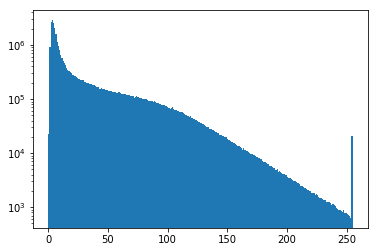

In [346]:
plt.hist(img_orig.ravel(), bins=256)
#plt.xscale('log')
plt.yscale('log')
None

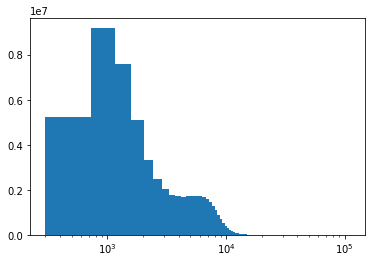

In [144]:
plt.hist(img_res.ravel(), bins=256)
plt.yscale('log')
# plt.xscale('log')
None